<div class="alert alert-block" style = "background-color: black">
    <p><b><font size="+4" color="orange">Other Issues in Regression</font></b></p>
    <p><b><font size="+2" color="white">Non-Linearity,Error Correlation, Heterodasticity, Outliers, High Leverage & Influential Points, Collinearity</font></b></p>
    </div>

* **Import Packages**

In [52]:
import numpy as np
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
import scipy
from scipy import linalg
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

* **Import Data Visualization packages**

In [53]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb;sb.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({'font.size':14}) #sets global font size


---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">Introduction</font></b></p>
    </div>
    
---

There are many problems that may arise when trying to fit a linear regression model to a particular dataset. The most common of these are as follows:

1. Non-linearity of the response-predictor relationships
2. Correlation of the error terms
3. Variability of the variance of error terms
4. Outliers
5. High-leverage points
6. Collinearity

All these can be investigated by conducting **Residual Analysis**.

The basic idea of residual analysis is to investigate the observed residuals to see if they behave “properly.” That is, we analyze the residuals to see if they support the assumptions of linearity, independence, normality and equal variances.

---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">1. Non-Linearity of the Response-Predictor relationship</font></b></p>
    </div>
    
---

The fundamental assumption in a linear regression problem is that there is a linear relationship between the response and the predictors. If that relationship is not truly linear, then the conclusions drawn from such a study are all suspect.

A good established practice to identify all non-linearity in a response-predictor relationship is to use **residual plots**.

For a simple linear regression model:
* we plot the residuals $e_{i} = Y_{true} - Y_{pred} \text{versus predictor}, x_{i}$
For a multiple linear regression model:
* We plot the residuals versus the predicted values,$Y_{pred}$

### **How do we identify non-linearity using residual plots?**
The residual plot will show an obvious pattern. The prescence of a pattern may show a potential problem with some aspect of the linear model.

We shall use the **Auto** dataset to illustrate this. 

## **Example - Residual Analysis to explore Non-linearity**

* **Load the data**

In [54]:
import warnings
warnings.filterwarnings('ignore')
Auto = pd.read_csv('../../../Data/ISLP_DATA/Auto.csv',na_values='?')
Auto = Auto.dropna(0,'any')
Auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

* **Perform the regression and obtain the residuals and predictions**

 **For the Linear Model - Regress mpg onto horsepower**

In [55]:
SLR_LinearModel = sm.OLS.from_formula('mpg ~ horsepower',Auto).fit()
ypred_deg1 = SLR_LinearModel.predict()
Linear_residuals = SLR_LinearModel.resid


* **Plot the Residuals against the Fitted Values**

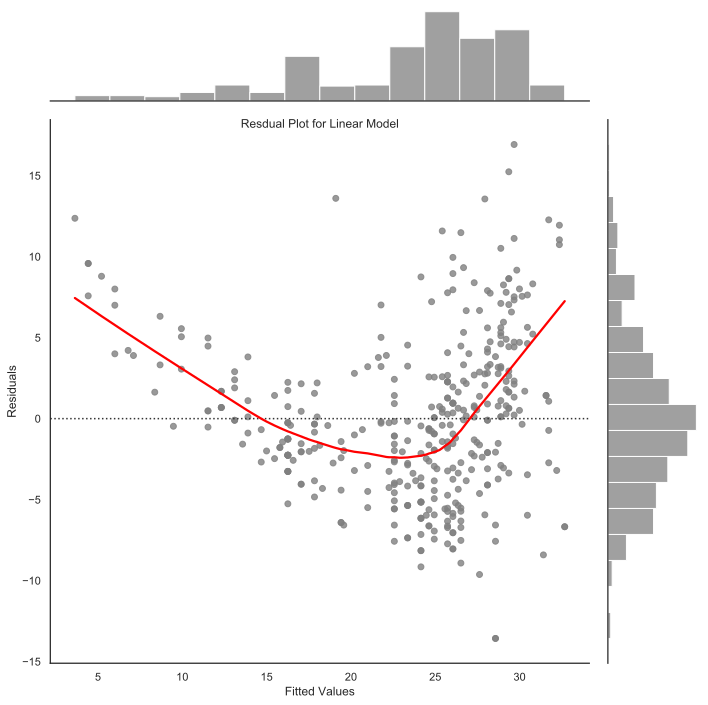

In [56]:
df = pd.DataFrame({'Fitted Values': ypred_deg1,'Residuals':Linear_residuals })

with sb.axes_style('white'):
    g = sb.jointplot(x= 'Fitted Values',y = 'Residuals',data=df,height=10,kind='resid',color="grey",joint_kws={'line_kws':{'color':'red'}},lowess=True);
plt.title('Resdual Plot for Linear Model',pad=-8);

* **For the Quadratic Model - Regress mpg also onto horsepower**

In [57]:
horsepower2 = np.power(Auto.horsepower,2)
MLR_NonLinearModel = sm.OLS.from_formula('mpg ~ horsepower + horsepower2 ',Auto).fit()
ypred_deg2 = MLR_NonLinearModel.predict()
Quadratic_residuals = MLR_NonLinearModel.resid

* **Plot the Residuals**

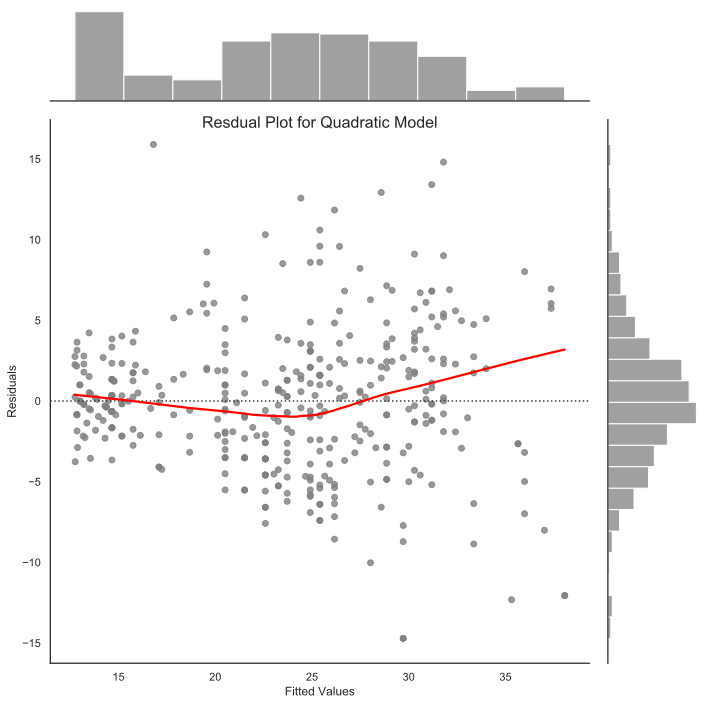

In [58]:
df = pd.DataFrame({'Fitted Values': ypred_deg2,'Residuals':Quadratic_residuals})

with sb.axes_style('white'):
    g = sb.jointplot(x = 'Fitted Values',y = 'Residuals',data=df,height=10,kind='resid',color="grey",joint_kws={'line_kws':{'color':'red'}},lowess=True);
plt.title('Resdual Plot for Quadratic Model',pad=-8, fontsize=16);

In the upper residual plot, the residuals exhibit a clear U-shape which **provides a clear indication of non-linearity between the response and the predictor.** As opposed to the plot below for the Quadratic Model where a fairly non-linear curve is fitted to the residuals **suggesting that the quadratic term improves the fit to the data**

In the indication of a non-linearity in the data, the next logical step is to use a non-linear transformation of the predictors such as logX, √X and $X^{2}$ in the regression model.

In a Multiple Linear Regression, a **residual** vs **predictor** plot would be required to know if a new predictor variable should be added to the model.If a pattern is observed the plot, then it implies that adding the predictor variable to the model would explain the remaining variability in the response. 

---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">2. Correlation of Error Terms</font></b></p>
    </div>
    
---

In creating predictive models in linear regression, another underlying assumption is that the error terms are uncorrelated. This is an extremely important assumption in statistical modelling. If a correlation exists, this implies that the standard errors computed for the estimated regression coefficients underestimate the true standard errors. The true standard errors in turn define the width of our confidence intervals which will as result become narrower and lead to an unwarranted sense of confidence in our model.

### **Why does Correlation exists in Error terms?**

This is common in time series data - data collected at adjacent time points. A positive correlation in the error terms can be investigated  by plotting the residuals as a function of time. A no-correlation stems from no discernible pattern while a positive correlation stems from adjacent residuals having similar values.

**We shall illustrate this phenomenon using the Advert sales data**

In [59]:
Advert = pd.read_csv("../../../Data/ISLP_Data/Advertising.csv")
Advert.head()

Unnamed: 0     TV  radio  newspaper  sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9

* **Regress Sales onto TV Advert data**

In [60]:
X = pd.DataFrame({'intercept':np.ones(Advert.shape[0]),'TV Advert Data':Advert['TV'],'Radio Data':Advert['radio']})
Y = Advert.sales
Linear_regmodel = sm.OLS(Y,X).fit()


* **Plot the Residuals**

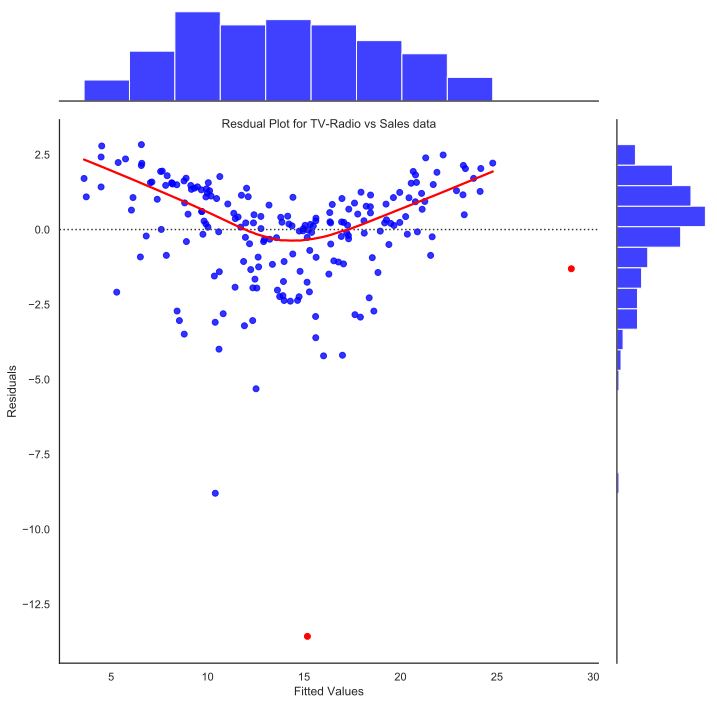

In [61]:
df = pd.DataFrame({'Fitted Values': Linear_regmodel.predict(),'Residuals':Linear_regmodel.resid })

with sb.axes_style('white'):
    g = sb.jointplot(x = 'Fitted Values',y = 'Residuals',data=df,height=10,kind='resid',color="blue",joint_kws={'line_kws':{'color':'red'}},lowess=True);
    plt.scatter(Fitted_values[130],Linear_residuals[130],marker='o',color='red')
    plt.scatter(Fitted_values[155],Linear_residuals[155],marker='o',color='red')
    plt.title('Resdual Plot for TV-Radio vs Sales data',pad=-8);
plt.savefig("05_Heterodasticity Present.png");

<div class="alert alert-block" style= "background-color: black">
    <p75><font color="white">&#9673</font><b><font size="+1" color="white">Heteroscedasticity</font></b></p75>
    <p><b><font color="white">The funnel shape observed above indicates heteroscedasticity. This refers to a situation where the variance of the residuals is unequal over a measured range of values.</font></b></p>
    </div>

---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">3. Heteroscedasticity - Variability of the variance of error terms</font></b></p>
    </div>
    
---

Linear regression holds a number of assumptions, one of which is that the error terms have a constant variance, $Var(∈_{i}) = 𝜎^{2}$. This assumption holds for the standard errors, confidence intervals and hypothesis tests associated with the linear model.

But the variances of the error terms may increase with the response variable. A possible solution to this problem is to transform the response Y using a concave function like logY or √Y. This brings about a shrinkage of the larger responses, leading to a reduction in heteroscedasticity

* **Resolve the variability and Plot the residuals**

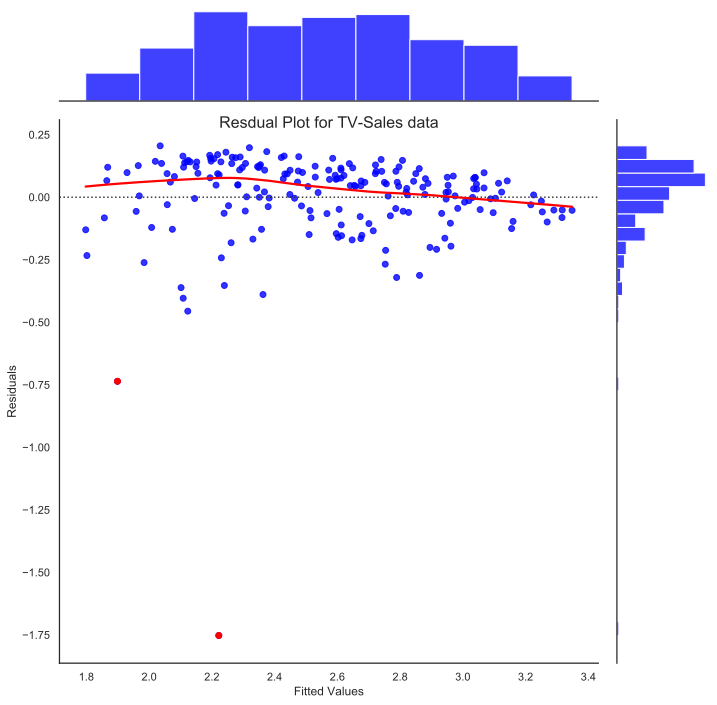

In [62]:
Ylog = np.log(Y)
LogLinear_regmodel = sm.OLS(Ylog,X).fit()
LogFitted_values = LogLinear_regmodel.predict()
LogLinear_residuals = LogLinear_regmodel.resid 
df = pd.DataFrame({'Fitted Values': LogLinear_regmodel.predict(),'Residuals':LogLinear_regmodel.resid })

with sb.axes_style('white'):
    g = sb.jointplot(x='Fitted Values',y='Residuals',data=df,height=10,kind='resid',color="blue",joint_kws={'line_kws':{'color':'red'}},lowess=True);
    plt.scatter(LogFitted_values[130],LogLinear_residuals[130],marker='o',color='red')
    plt.scatter(LogFitted_values[155],LogLinear_residuals[155],marker='o',color='red')
    plt.title('Resdual Plot for TV-Sales data',pad=-8, fontsize=16);
plt.savefig("05_Heterodasticity Resolved.png");

---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">4. Outliers</font></b></p>
    </div>
    
---

Outliers arise for a variety of reasons such as incorrect measurement or recording of observations during data collection. 

An Outlier is a point for which its observational value is far from the predicted value by the model. Such a point may influence the slope and intercept of the regression line. Other problems that ensue from having outliers is a decrease in the R-squared value and an increase in the RSE, root mean squared error value. The RSE is used to compute confidence intervals and p-values and as such an outlier can have implications for the model interpretation.

To address this problem, the outliers can be identified from a studentized residual plot which is computed by dividing each residual with its estimated standard error. Observations whose studentized residuals are greater than 3 are possible outliers.

An outlier may be removed if found to be due to error in data collection but care must be taken as it may also be due to a deficiency with the model.

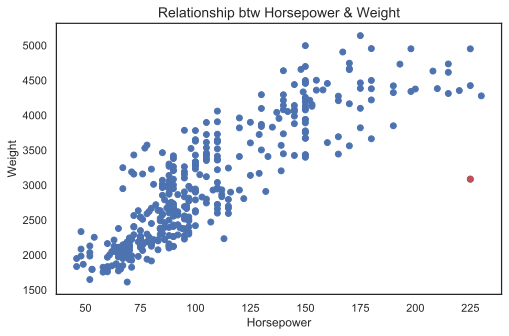

In [63]:
plt.figure(figsize=(8,5))
plt.scatter(Auto.horsepower,Auto.weight,marker='o',color='b')#
plt.scatter(Auto.horsepower[13],Auto.weight[13],marker='o',color='r');
plt.xlabel('Horsepower')
plt.ylabel('Weight')
plt.title('Relationship btw Horsepower & Weight',fontsize=14);

* **First fit the full data to the model** 

In [64]:
X = pd.DataFrame({'intercept':np.ones(Auto.shape[0]),'horsepower':Auto['horsepower']})
Y = Auto.weight
XY = pd.concat([X,Y],axis=1)
Linear_regmodel1 = sm.OLS(Y,X).fit()

* **Evaluate Model**

In [65]:
from statsmodels.tools.eval_measures import rmse

Reg_Results = summarize(Linear_regmodel1)
print(Reg_Results,"\n","R squared value",Linear_regmodel1.rsquared)
print("\n","Regression Eqn:",'y ='+ str(Reg_Results['coef'].intercept) + ' ' '+' ' ' + str(Reg_Results['coef'].horsepower) +'_X1')

ypred = Linear_regmodel1.predict()
RMSE = rmse(Y,ypred)
RMSE

                coef  std err       t  P>|t|
intercept   984.5003   62.514  15.748    0.0
horsepower   19.0782    0.562  33.972    0.0 
 R squared value 0.7474254996898198

 Regression Eqn: y =984.5003 + 19.0782_X1


426.3376254563709

* **Determine the Outliers using a boxplot**

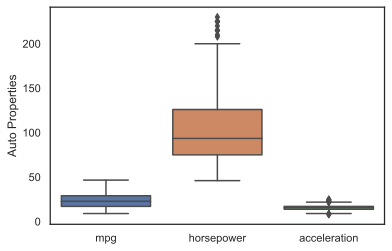

In [66]:
fig,ax1 = plt.subplots(ncols=1)
sb.boxplot(data = Auto[['mpg','horsepower','acceleration']],ax=ax1)
ax1.set_ylabel('Auto Properties');

There is a huge advert budget spent on TV compared to the other two media outlets. No outliers seem present in the TV and radio data but the newspaper data seems to have two present. These may be insignificant and may have little effect on the regression model but an outlier test may confirm our hypothesis.

* **Drop the Outliers**

In [67]:
outliers = Auto[(Auto['horsepower']==225) & (Auto['weight']<3500)].index
Auto_no_out = Auto.drop(index=outliers,inplace=False)

In [68]:
X_dropped = pd.DataFrame({'intercept':np.ones(Auto_no_out.shape[0]),'horsepower':Auto_no_out['horsepower']})#'TVData':Advert_dropped['TV'],'Radio Data':Advert_dropped['radio']})
Y_dropped = Auto_no_out.weight
XY_dropped = pd.concat([X_dropped,Y_dropped],axis=1)

* **Fit the data to the model with the outliers dropped**

In [69]:
Linear_regmodel_dropped = sm.OLS(Y_dropped,X_dropped).fit()

Reg_Results_dropped = summarize(Linear_regmodel_dropped)
print(Reg_Results_dropped,"\n","R squared value",Linear_regmodel.rsquared)
print("\n","Regression Eqn:",'y ='+ str(Reg_Results_dropped['coef'].intercept) + ' ' '+' ' ' + str(Reg_Results_dropped['coef'].horsepower) +'_X1')

yhat = Linear_regmodel_dropped.predict()
RMSE_dropped = rmse(Y_dropped,yhat)
RMSE_dropped

               coef  std err       t  P>|t|
intercept   941.269   60.919  15.451    0.0
horsepower   19.547    0.549  35.577    0.0 
 R squared value 0.8971942610828956

 Regression Eqn: y =941.269 + 19.547_X1


411.8268341233839

* **Plot the Regression with both the outliers present and absent**

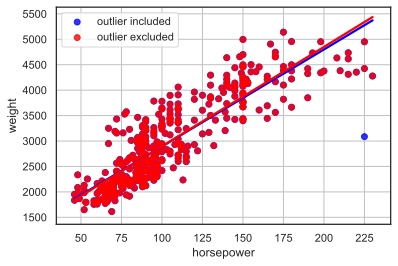

In [70]:
fig,axs = plt.subplots(ncols=1)
sb.regplot(x='horsepower',y='weight',data=XY,ax=axs,marker='o',color='blue',line_kws={'color':'blue'},label='outlier included',ci=None)
sb.regplot(x='horsepower',y='weight',data=XY_dropped,ax=axs,marker='o',color='red',line_kws={'color':'red'},label='outlier excluded',ci=None)
axs.legend()
plt.grid(color='silver');

## **Observation**

It is hard to set the two regression lines apart. The blue line represents the estimated regression with the blue outlier included while the red line represents the estimated regression line with the blue outliers absent. 

The slopes of the two regression lines differ by a small margin but a major increase is observed in the R-squared value from 0.747 to 0.897 but the relationship between the response and the variable is still strong with our p-values in both cases at 0.00.

The standard error of the predictor variable (horsepower) also drops for the model with the outlier excluded likewise that of the intercept thus narrowing our confidence interval.

**Conclusion:** This major shift in the R-squared value caused by the removal of just one data point may have serious implications for the interpretationof the model. The outlier, seems to be a high leverage point, has an effect on the model coefficients and test-statistics and as such would be investigated further for any influence on the model.


---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">5. High Leverage and Influential Points</font></b></p>
    </div>
    
---

This section duscusses **leverages** and how they help identify extreme predictor values.

A predictor variable with an unusual observation value is considered to have a high leverage.In a simple linear regression, a high leverage point is fairly easy to identify since we simply look for observations whose predictor value is out of the normal range.In a multiple linear regression, we compute the leverage statistic because there is no simple way to plot all the dimensions of the data simultaneously.

$$
\text{leverage,}h_{i} = \frac{1}{n} + \frac{(x_{i}-\bar x)^{2}}{∑_{i^{'}}^{n}(x_{i^{'}} - \bar x)^2}
$$

The predicted response can be written as a function of the leverage as follows:

$$
\hat y_{i} = h_{i1}y_{1} + h_{i2}y_{2}+... +h_{ii}y{i}+...h_{in}y{n} \text{for i = 1,...,n}
$$

The leverage quantifies the influence the observed response,$Y$ has on the predicted response $\hat Y$. 

* **Points to Note**
1. $h_{i}$ increases with distance of $x_{i}$ from $x$
2. $h_{i}$ is always between $\frac{1}{n}$ and 1
3. Average leverage for all observations is equal to $\frac{(p+1)}{n}$


### **Identifying high leverage points**

Leverage threshold is $3 \left(\frac{p+1}{n}\right)$. Anything greater than this is a high leverage point. A high leverage point may or may not be influential beacause it takes to account only the extreme values of the predictors. It is only influential if it influences the regression model. 

* **Get influence summary**

In [71]:
influence = Linear_regmodel1.get_influence()
influence_summ = influence.summary_frame()
influence_summ.head()

dfb_intercept  dfb_horsepower   cooks_d  standard_resid  hat_diag  \
0      -0.001295        0.003095  0.000016        0.092205  0.003676   
1       0.059327       -0.082495  0.004774       -1.032592  0.008876   
2       0.037367       -0.057762  0.002858       -0.962703  0.006130   
3       0.037640       -0.058185  0.002900       -0.969743  0.006130   
4       0.012784       -0.022632  0.000557       -0.484134  0.004730   

   dffits_internal  student_resid    dffits  
0         0.005601       0.092088  0.005594  
1        -0.097717      -1.032680 -0.097725  
2        -0.075604      -0.962613 -0.075597  
3        -0.076157      -0.969669 -0.076151  
4        -0.033376      -0.483658 -0.033343

* **Plot the standardized residuals to check for any anomaly > 3**

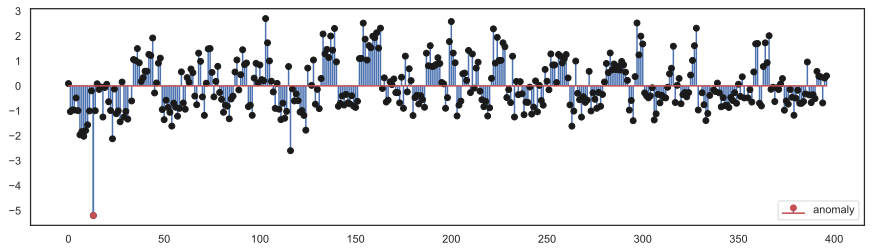

In [72]:
plt.figure(figsize=(15,4))
plt.stem(influence_summ.standard_resid.index,influence_summ.standard_resid,markerfmt='ko',use_line_collection=True)
plt.stem(influence_summ.standard_resid.index[influence_summ.standard_resid< (-3)],influence_summ.standard_resid[influence_summ.standard_resid< (-3)],markerfmt='ro',use_line_collection=True,label='anomaly') 
plt.legend(loc='lower right');

* **Identify the observation point with anomalous standardized residual**

In [73]:
influence_summ.standard_resid[influence_summ.standard_resid < -3].index
Auto.weight[13]
Auto.name[13]
Anomaly = {'Car Brand':Auto.name[13],' Car Weight':Auto.weight[13]}
Anomaly

{'Car Brand': 'buick estate wagon (sw)', ' Car Weight': 3086}

### **Observation**

This observation point has an anomalous value of -5. This is a far cry from an unexpected anomaly greater than 3. This is the same observation initially classed as an outlier.It happens to be a lightweight vehicle (3086 units) with a horsepower greater than 225. Other cars in its class of 225mph are heavy vehicles with weights in excess of 4000 units. 

* **Plot of the studentized residual versus the leverage values**

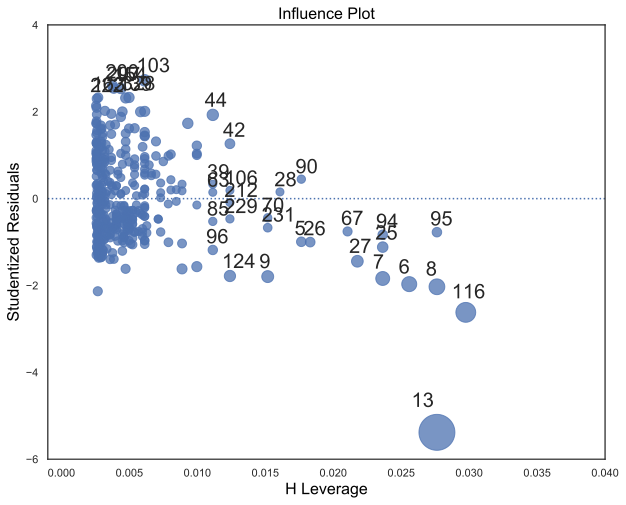

In [74]:
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import influence_plot
ax = sm.graphics.influence_plot(Linear_regmodel1,criterion="cooks",size=36,alpha=0.025)
ax.set_figheight(8)
ax.set_figwidth(10)
plt.axhline(y=0.0,linestyle=':')
plt.xlim([-0.001,0.04])
plt.ylim([-6,4])
plt.show()

### **Identifying Influential Points**

In this section, we learn two measures of identifying influential points:

* Difference of Fits (DFFITS)
* Cooks Distance

The basic idea in each of these measures is to delete  each observation one at a time and fit the data with the n-1 observations and comparing the regression results of the n-1 observations with the regression done with n observations to see if the deleted observation is influential.

### **Difference of Fits**

An observation is deemed influential if the absolute value of the **difference of fits** is greater than:

$$
dffits > 2 \sqrt \frac{k + 2}{n -k -2} \text {where k is no. of predictors in the regression model}
$$

**or simply put, highly unsual compared to the rest of the observations**

* **Make a stem plot to observe the unsual dffits values**

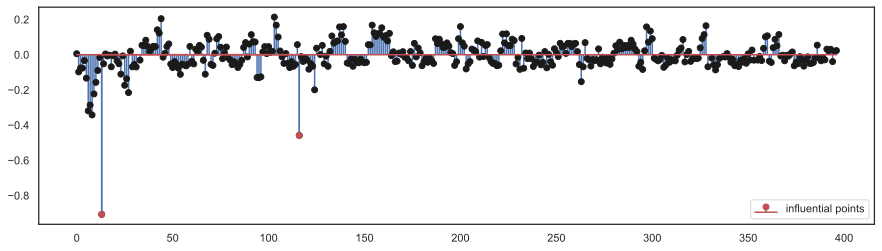

In [75]:
dffits = 2*np.sqrt((1 + 2)/(392 -1 -2))
plt.figure(figsize=(15,4))
plt.stem(influence_summ.dffits.index,influence_summ.dffits,markerfmt='ko',use_line_collection=True)
plt.stem(influence_summ.dffits.index[influence_summ.dffits< (-0.4)],influence_summ.dffits[influence_summ.dffits< (-0.4)],markerfmt='ro',use_line_collection=True,label='influential points') 
plt.legend(loc='lower right');

* **Extract the observation points with anomalous dfits values > dffits criterion**

In [76]:
influence_summ.dffits[influence_summ.dffits>dffits]

44     0.204666
103    0.213823
Name: dffits, dtype: float64

### **Observation**

The two anomalous values observed here are of indices 44 & 103 respectively and are not the ones indicated with the studentized residual and standardized residual plot. They do not have a high leverage and the studentized residuals are not greater than 3. The reason for this unexpected choice of influential points will be further confirmed with the cooks distance method. 

### **Cook's Distance**

The guidelines to consider when using cook's distance are as follows:

1. If the cook's distance is **greater than 0.5**, then the $i^{th}$ data point may be worthy of investigation. It may be influential

2. If the cook's distance is **greater than 1**, the $i^{th}$ data point may be influential

3. Or if the cook's distance is **unreasonably unusual**, then the $i^{th}$ data point is influential

* **Make a stem plot to observe the unusual cooks distances**

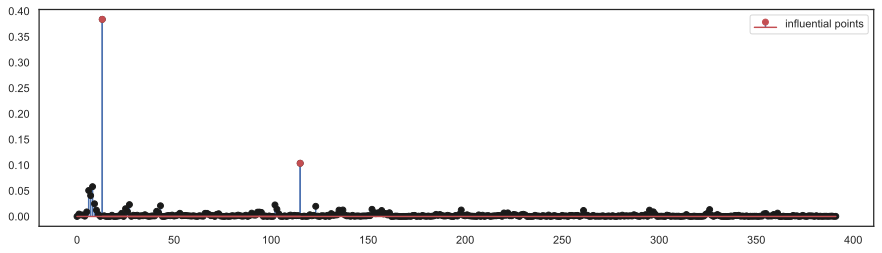

In [77]:
(cooks,_) = influence.cooks_distance

plt.figure(figsize=(15,4))
plt.stem(np.arange(len(cooks)),cooks,markerfmt='ko',use_line_collection=True)
plt.stem(np.arange(len(cooks))[cooks>0.1],cooks[cooks>0.1],markerfmt='ro',use_line_collection=True,label='influential points') 
plt.legend(loc='upper right');

## **Observation**

The two points with anomalous cook distances are of indices 13 and 116.Their respective cook distances are 0.38 and 0.1 respectively. They are the ones with the biggest circles on the influence plot. These values are not up to the 0.5 stipulated in the cook's guideline but are distinctly unusual compared to other cook distances. This suggests they are influential points. Point 13 has already established itself as an influential candidate with the significant increase in R-squared value observed when it was removed prior to regression


---
<div class="alert alert-block" style="background-color: black">
    <p><b><font size="+2" color="white">6. Collinearity</font></b></p>
    </div>
    
---

Collinearity refers to a situation in which two or more predictor variables are positively related or negatively related. This cretaes a problem in regression analysis because it is difficult to separate out the individual effects of collinear variables on the response.

* Collinearity reduces the accuracy of the estimates of the regression coefficients $\hat \beta$
* It causes the standard error of the coefficients to grow
* It causes a decline in the t-statistic because the t-statistic of each predictor is calculated by dividing $\hat \beta$ by its standard error
* This ultimately reduces the power of the null hypothesis test i.e the probability of correctly having a non-zero coefficient is reduced.

**To identify and address potential collinearity problems**

* A preliminary action is to look at the correlation matrix of the predictors but collinearity could still exist between 3 or more variables even with no high correlation. This is called multicollinearity.

* A better approach is to compute the variance inflation factor (VIF). This is the ratio of the variance of $\hat \beta_{i}$ when fitting the full model divided by the variance of $\hat \beta_{i}$ when fit on its own.

> Smallest possible value of VIF = 1 and indicates NO collinearity
> A VIF that exceeds 5 or 10 indicates problematic collinearity

### **How to handle Collinearity**

* Drop one of the problematic variables from the regression because the prescence of collinearity implies that the information this variable provides about the response is redundant.

    * To do this, drop the predictor and compute the VIF, is it close to 1 and does $R^{2}$ improve?

* Second option is to combine the collinear variables together into a single predictor. E.g taking the average of the standarddized versions of limit & rating in Credit dataset can create a new variable called **credit worthiness**

The predictors exhibit multicollinearity between each other as shown below:

In [78]:
pd.plotting.scatter_matrix(Auto,alpha=0.2,figsize=(15,8));

**Multicollinearity will be checked while performing a multiple linear regression of the predictors with the response variable.** 

* **Important things to note about the predictor and response variables**

**horsepower** - describes the power output i.e how much power an engine can produce

**Displacement** - describes the size of the engine of the car i.e the physical space in the engine between the 2 piston dead centers -large engine gives large displacement 

>hp 𝛂 amt of torque generated by crankshaft 𝛂 total disp (size of engine) 

**mpg** - is the distance travelled per unit volume of fuel used.The higher the value, the more economic the vehicle is.i.e the more distance it can travel with a certain volume of fuel.

**weight** - is the weight of the vehicle. Reducing mass reduces the energy necessary to move a vehicle, and thus reduces fuel consumption.

**Acceleration** - is rate at which a vehicle reaches a certain speed

**Cylinders** - refers to the number of cylinders in the engine of the car. 4,6 & 8. Smaller cylinders report higher fuel ecnomy than larger ones. 
